In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

from src.V1_Compress import generate_Y, compress
import pandas as pd
import itertools
import dask
from dask.distributed import Client, progress
import seaborn as sns
import time
import os.path

In [ ]:
num_cell = 500

In [2]:
working_img = 'city_part3.png'

In [37]:
# Work on previously saved data
params_df = pd.read_csv('result/{img}/V1/param_Tue_Jul_12_15_29_48_2022.csv'.format(img = working_img.split('.')[0]))
# results_df = pd.read_csv('result//results_Mon_May_23_21_46_49_2022.csv')
# total_df = pd.read_csv('result//total_Mon_May_23_21_47_07_2022.csv')

In [38]:
for index in params_df.columns:
    if (index == 'Unnamed: 0') :
        params_df.drop('Unnamed: 0', axis = 1, inplace=True)

# for index in results_df.columns:
#     if (index == 'Unnamed: 0') :
#         results_df.drop('Unnamed: 0', axis = 1, inplace=True)
# for index in total_df.columns:
#     if (index == 'Unnamed: 0') :
#         total_df.drop('Unnamed: 0', axis = 1, inplace=True)


In [39]:
params_df = params_df[params_df['num_cell'] == num_cell]

In [48]:
params_df.head()

,rep,alp,num_cell,cell_sz,sparse_freq,error
18,0,0.001,500,2,1,131.024109
19,0,0.001,500,2,2,704.791515
20,0,0.001,500,2,5,1039.406782
21,0,0.001,500,5,1,161.037582
22,0,0.001,500,5,2,741.112405


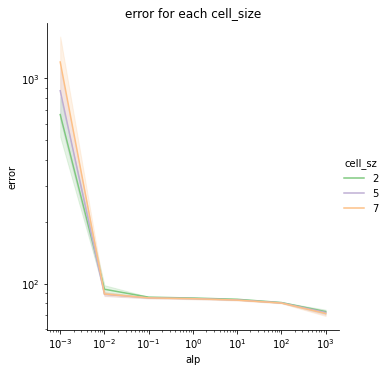

In [40]:
save_path = os.path.join('./result/{img}/V1/'.format(img = working_img.split('.')[0]))
fig = sns.relplot(data = params_df, x = 'alp', y = 'error', kind='line', palette='Accent', hue = 'cell_sz')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each cell_size')
# fig.savefig(os.path.join(save_path, "alpha_error_per_size" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".png"), dpi = 200)

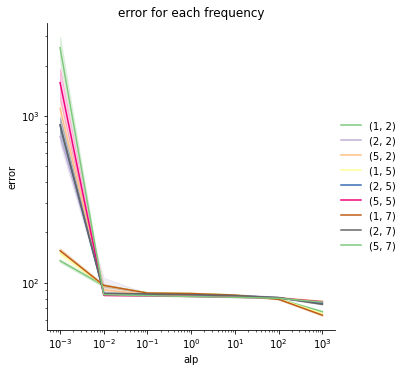

In [41]:
save_path = os.path.join('./result/{img}/V1/'.format(img = working_img.split('.')[0]))
fig = sns.relplot(data = params_df, x = 'alp', y = 'error', kind='line', palette='Accent', 
                  hue = params_df[['sparse_freq', 'cell_sz']].apply(tuple, axis = 1))
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each frequency')
# fig.savefig(os.path.join(save_path, "alpha_error_per_hyperparam_" + "_".join(
#     str.split(time.ctime().replace(":", "_"))) + ".png"), dpi = 200)

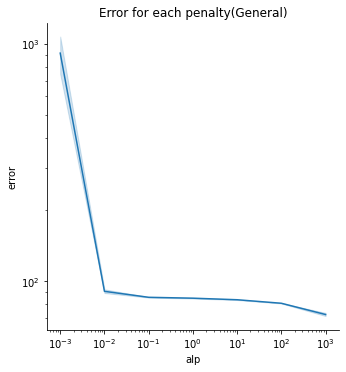

In [42]:
save_path = os.path.join('./result/{img}/V1'.format(img = working_img.split('.')[0]))
fig = sns.relplot(data = params_df, x = 'alp', y = 'error', kind='line')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='Error for each penalty(General)')
# fig.savefig(os.path.join(save_path, "alpha_error_general" + "_".join(
#     str.split(time.ctime().replace(":", "_"))) + ".png"), dpi = 200)

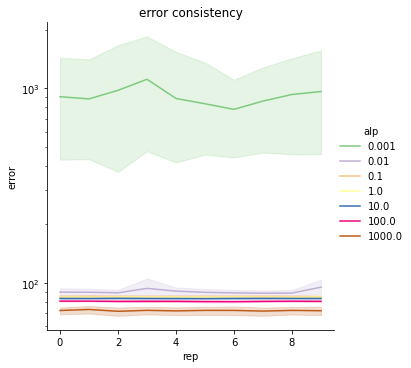

In [43]:
# To show how consistent randomly generated V1 weight would be for each rep. it should be about same for each repetition
save_path = os.path.join('./result/{img}/V1/'.format(img = working_img.split('.')[0]))
fig = sns.relplot(data = params_df, x = 'rep', y = 'error', kind='line', palette='Accent', hue = 'alp')
fig.set(title='error consistency')
fig.set(yscale='log')
# fig.savefig(os.path.join(save_path, "alpha_error_consistency" + "_".join(
#     str.split(time.ctime().replace(":", "_"))) + ".png"), dpi = 200)

In [44]:
params_df.groupby(by=['num_cell', 'cell_sz', 'sparse_freq', 'alp']).mean().sort_values(
    by='error', ascending= True).drop('rep', axis = 1).head(1)

,,,,error
num_cell,cell_sz,sparse_freq,alp,
500,7,1,1000.0,63.809992


In [45]:
params_df.groupby(by=['num_cell', 'cell_sz', 'sparse_freq', 'alp']).mean().drop('rep', axis = 1)

error
num_cell cell_sz sparse_freq alp                 
500      2       1           0.001     135.174157
                             0.010      95.806225
                             0.100      86.837771
                             1.000      85.939963
                             10.000     84.378132
...                                           ...
         7       5           0.100      83.488258
                             1.000      82.552096
                             10.000     81.604943
                             100.000    80.498505
                             1000.000   76.414034

[63 rows x 1 columns]

In [46]:
compress_param_df = pd.read_csv('result/{img}/Classical/Classical_Param_Tue_Jul_12_15_40_34_2022.csv'.format(img = working_img.split('.')[0]))
for index in compress_param_df.columns:
    if (index == 'Unnamed: 0') :
        compress_param_df.drop('Unnamed: 0', axis = 1, inplace=True)
compress_param_df = compress_param_df[compress_param_df['classical_samp'] == num_cell]

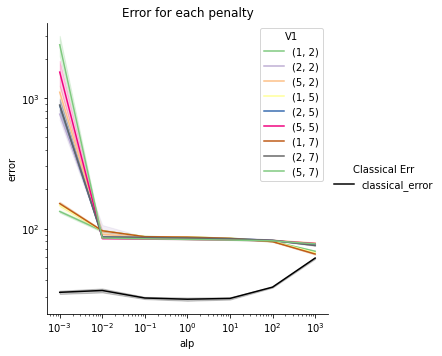

In [47]:
save_path = os.path.join('./result/{img}/'.format(img = working_img.split('.')[0]))
fig = sns.relplot(data = params_df, x = 'alp', y = 'error', kind='line', palette='Accent', 
                  hue = params_df[['sparse_freq', 'cell_sz']].apply(tuple, axis = 1), legend = False)

fig.set(title='Error for each penalty')
fig.map(sns.lineplot, x = 'alpha', y = 'error', data = compress_param_df, 
        label= 'classical_error', color = 'black', legend = True).add_legend(title='Classical Err', loc = 'right')
fig.set(yscale='log')
fig.set(xscale='log')
plt.legend(title = 'V1', labels =['(1, 2)', '(2, 2)', '(5, 2)', '(1, 5)', '(2, 5)', '(5, 5)', '(1, 7)', '(2, 7)', '(5, 7)'])
# plt.legend(title = 'Classical', label = ['classic'])
# fig.savefig(os.path.join(save_path, "Error_for_each_penalty_" + "_".join(
#     str.split(time.ctime().replace(":", "_"))) + ".png"), dpi = 200)


In [ ]:
save_path = os.path.join('./result/{img}/Classical/'.format(img = working_img.split('.')[0]))


compress_fig = sns.relplot(data = compress_param_df, x = 'alpha', y = 'error', kind= 'line')
compress_fig.set(yscale='log')
compress_fig.set(xscale='log')
plt.title('Classical: Error for each penalty')
compress_fig.savefig(os.path.join(save_path, "Error_for_each_penalty_" + "_".join(
    str.split(time.ctime().replace(":", "_"))) + ".png"), dpi = 200)
plt.show()

In [ ]:
temp_err = params_df.groupby(['num_cell', 'sparse_freq', 'cell_sz', 'alp']).agg({'error':'mean'})

## Error Vs Num_Cell Graph

In [ ]:
line_data['num_cell'].value_counts().sum()

In [ ]:
min_mean_err_df = pd.DataFrame()
for i in mean_err['num_cell'].unique():
    temp = mean_err.loc[mean_err['num_cell'] == i]
    #hyperparameter for each number of cell
    ## Grabbing values by each values
    min_mean_err_df = min_mean_err_df.append(temp.loc[temp['error'] == temp['error'].min()])
    
# Merge two data to extract
min_mean_err_df = min_mean_err_df.rename(columns={'error' : 'mean_err'})
merged_df = pd.merge(params_df, min_mean_err_df, on = ['num_cell', 'sparse_freq', 'cell_size', 'alpha'], how = 'left')
plotting_data = merged_df.loc[merged_df['mean_err'].notnull()]

In [ ]:
params_df[(min_err_df.iloc[:, 0:4].head(1).values == params_df.iloc[:, 1:5].values).all(axis=1)]

In [ ]:
num_cell_error_df = pd.DataFrame()
min_err_df = min_err_df.reset_index(drop = True)
for i in range(len(min_err_df)):
    print(i)
    num_cell_error_df = num_cell_error_df.append(params_df[
        (min_err_df.iloc[:, 0:4].iloc[i].values == params_df.iloc[:, 1:5].values).all(axis=1)])
    

In [ ]:
params_df[['num_cell', 'cell_size', 'sparse_freq', 'alpha']].values

In [ ]:
params_df.iloc[params_df[['num_cell', 'cell_size', 'sparse_freq', 'alpha']].values == min_err_df.iloc[:, 0:4].iloc[0].values]

In [ ]:
min_err_df.reset_index(drop = True).iloc[:, 0:4].iloc[1].values

In [ ]:
params_df[(min_err_df.iloc[:, 0:4].iloc[2].values == params_df.iloc[:, 1:5].values).all(axis=1)]

In [ ]:
num_cell_error_df

In [ ]:
# params_df[(min_err_df.iloc[:, 0:4].loc[1].values == params_df.iloc[:, 1:5].values).all(axis=1)]
params_df.iloc[:, 1:5]

In [ ]:
min_err_df.iloc[:, 0:4].iloc[1].values

In [ ]:
params_df.iloc[:, 1:5].values

In [ ]:
np.unique((min_err_df.iloc[:, 0:4].iloc[1].values == params_df.iloc[:, 1:5].values).all(axis=1))

In [ ]:
# params_df[params_df["num_cell"] == 200.] & params_df[params_df["cell_size"] == 2.]

In [ ]:
min_err_df.iloc[:, 0:4].iloc[1].values